In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler #Standardizes features for effective clustering
from sklearn.cluster import KMeans 
import random
from scipy.spatial.distance import euclidean # For calculating euclidean distance between two feature vectors

# Step 1: Loading Datasets

Here, we load a dataset containing a huge list of songs from Spotify including multiple features such as acousticness, danceability, energy, and so on. We have multiple sets, so we preprocess them by combining them into one workable dataset

In [2]:
# loading data
file_path_april = 'feature_data/SpotifyAudioFeaturesApril2019.csv'
file_path_november = 'feature_data/SpotifyAudioFeaturesNov2018.csv'

spotify_april = pd.read_csv(file_path_april)
spotify_november = pd.read_csv(file_path_november)

# combining
spotify_combined = pd.concat([spotify_april, spotify_november], ignore_index=True)

Here, we select the features that are relevant for the clustering. For example, features like artist_name, track_id, track_name, duration_ms, and so on do not describe of the song for this algorithm. 
    
We then standardize all of the features so that they have a mean of 0 and a standard deviation of 1 so that they can be used for clustering.

In [3]:
# clustering features
features = ['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 
            'loudness', 'speechiness', 'tempo', 'valence']

# standardization
scaler = StandardScaler()
song_features = scaler.fit_transform(spotify_combined[features])
spotify_combined['features'] = list(song_features)  # Store standardized features for distance calculations

# Step 2: K-means Clustering

In this section, we apply the K-means clustering algorithm. The term num_clusters and random_state can be adjusted depending on how diverse we want it, and can be experimented with later on. However, a good initial starting point is to plot an inertia graph of a range of clusters, trying to look for the elbow that decides how many clusters we want to pick. 

In this case, however, the elbow isn't extremely obvious, so we take an educated guess and set num_clusters to 7.

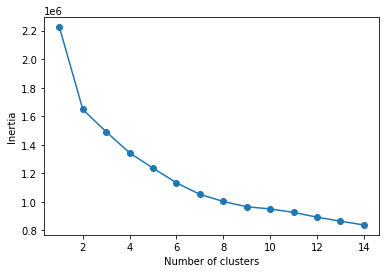

In [4]:
import matplotlib.pyplot as plt

# find inertia
inertias = []
for k in range(1, 15):
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(song_features)
    inertias.append(kmeans.inertia_)

# inertia plot
plt.plot(range(1, 15), inertias, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()


Now that we have decided the number of clusters, we fit the K-means model on song_features, assigning a cluster to each song as shown below in the dataframe. This can be implemented both using KMeans from sklearn.cluster or manually, setting the centroids randomly and then adjusting them to the average of the cluster positions.

In [5]:
# Apply K-means clustering
num_clusters = 7  # Adjust for diversity
kmeans = KMeans(n_clusters=num_clusters, random_state=0)
spotify_combined['cluster'] = kmeans.fit_predict(song_features)

# Step 3: Maximal Distance Selection Function

Here, we write a function to find the song that is most different from the previous added song based on euclidean distance. This way, we can maximize the variation of the song, helping the illusion of a true random shuffle. The function works like this:

1. Initialize the max_distance to something negative and selected_song to None, both to be replaced later
2. Iterate over every song in the cluster, calculating the "distance" from the last song's features
3. If the distance is greater than the max_distance, it becomes the new max_distance and the song is selected

In [6]:
# finding most different song
def select_maximally_different_song(last_song_features, cluster_songs):
    max_distance = -1
    selected_song = None
    
    for _, song in cluster_songs.iterrows():
        dist = euclidean(last_song_features, song['features'])
        if dist > max_distance:
            max_distance = dist
            selected_song = song
            
    return selected_song

# Step 4: Playlist Generation Function

   Here, we define the function for generating the shuffled playlist. The steps are as follows:
    
#### 1. Filter unplayed songs
    
- To ensure that there are no repeated songs, every song played will be tracked by the played_songs set, and the next songs selected are the ones not in the set.
        
#### 2. Select X number of unplayed songs
    
- Shuffling the entire dataset will take an extremely long time due to how massive it is, so we will deal with it in batches instead. Here, we select a random X number of songs from the total dataset. To ensure cluster diversity, we spread our selection across all clusters.
    
#### 3. Group the selected songs by their cluster assignment
    
- Taking these x songs, we group them depending on the cluster number assigned to them to prep for the cyclic traversal.
    
#### 4. Shuffle the clusters and then cycle through them, picking a random song from each one
    
- We shuffle the clusters to ensure that we don't cycle through them in the same order every run, and then pick a random song from each of these clusters.
    
#### 5. Add to playlist
    
- Each time we pick a random song, we add them into the playlist.

In [7]:
# tracking songs
played_songs = set()

def create_partial_playlist(songs, num_clusters, played_songs, batch_size=1000):
    """Generate a shuffled playlist ensuring diversity across clusters."""
    
    # filter played songs
    unplayed_songs = songs[~songs['track_id'].isin(played_songs)]
    if unplayed_songs.empty:
        return []
    
    # take songs from each cluster
    clusters = unplayed_songs.groupby('cluster')
    cluster_sample_size = max(1, batch_size // num_clusters)
    
    selected_songs = []
    for cluster_id, cluster_songs in clusters:
        selected_songs.append(cluster_songs.sample(n=min(cluster_sample_size, len(cluster_songs))))
    
    selected_songs = pd.concat(selected_songs, ignore_index=True)
    played_songs.update(selected_songs['track_id'].values)

    # shuffle clusters for diversity
    clusters = selected_songs.groupby('cluster')
    playlist = []
    last_cluster = None
    last_song_features = None

    while len(playlist) < batch_size and not selected_songs.empty:
        available_clusters = [c for c in clusters.groups.keys() if c != last_cluster]
        if not available_clusters:
            available_clusters = list(clusters.groups.keys())  # reset if needed

        random.shuffle(available_clusters)
        
        for cluster_id in available_clusters:
            cluster_songs = clusters.get_group(cluster_id)
            
            # maxing diversty
            if last_song_features is not None:
                next_song = select_maximally_different_song(last_song_features, cluster_songs)
            else:
                next_song = cluster_songs.sample(n=1).iloc[0]
            
            playlist.append((next_song['artist_name'], next_song['track_name']))
            last_song_features = next_song['features']
            last_cluster = cluster_id

            # removing played song (avoid repetition)
            selected_songs = selected_songs[selected_songs['track_id'] != next_song['track_id']]
            clusters = selected_songs.groupby('cluster')

            break
    
    return playlist[:batch_size]


# Step 5: Creating Playlist Batches

   Now that we have the function, we can generate the playlist. Due to the fact that we optimized by creating the playlist in batches of 50, if the number of songs played exceeds this we must prep a second batch. This is currently not automated, but can be done in the future.

In [8]:
playlist_batch_1 = create_partial_playlist(spotify_combined, num_clusters, played_songs)

for artist, song in playlist_batch_1:
    print(f"{artist} - {song}")

Slugdge - Transilvanian Fungus
Gladys Bucio - Una Noche Junto a Ti
Within Destruction - Downfall of Humanity
Wolfgang Amadeus Mozart - Le nozze di Figaro, K. 492, Act III: Che imbarazzo è mai questo! ...Via! fatti core (Live)
Portal - Husk
Unclenathannn - Pure Imagination (feat. Shiloh Dynasty)
Ephemeral Rift - Sleep for the Sleepless, Pt. 3: Pocket & Wallet Sounds
MYMP - Kailan
Johann Sebastian Bach - Cello Suite No. 2 in D Minor, BWV 1008: VI. Gigue
Jason Richardson - Tendinitis
Samson Oxmoor - The Cock and the Fox
P Stack - Pisces
Alice Glass - CEASE AND DESIST
Wolfgang Amadeus Mozart - La clemenza di Tito, K. 621, Act I: Parto, ma tu ben mio
HOK - Death 4any1 Who...
Johann Sebastian Bach - Goldberg Variations, BWV 988: Var. 4, à 1 Clav.
Borrtex - We Are Saved
El Chulo - Hasta el Piso
Thunderstorm Sleep - Rain at Night
Ying Yang Twins - Only 4 da Strip Club (feat. Chingy & Calicla$)
Water Sound Natural White Noise - Bobbing Waves
Jimijames - No Time
Johann Sebastian Bach - Weihnacht

# Step 6: Qualitative Metrics

In order to measure how well our algorithm performs, we break this down into qualitative (visual) and quantitative metrics. For the qualitative metrics, we will use PCA as well as a plot of how the algorithm traverses the clusters.

### Principle Component Analysis (PCA)

Here, we analyze how well we do through PCA dimensionality reduction. The function works as follows:

1. Pull out the songs from our specific batch so that we aren't doing PCA on the entire dataset (130k songs)
2. Extract 2 principle components to plot on a 2D plot for our own visualization
3. Plot the PCA results, color coding each cluster so we can see how our clustering algorithm performs

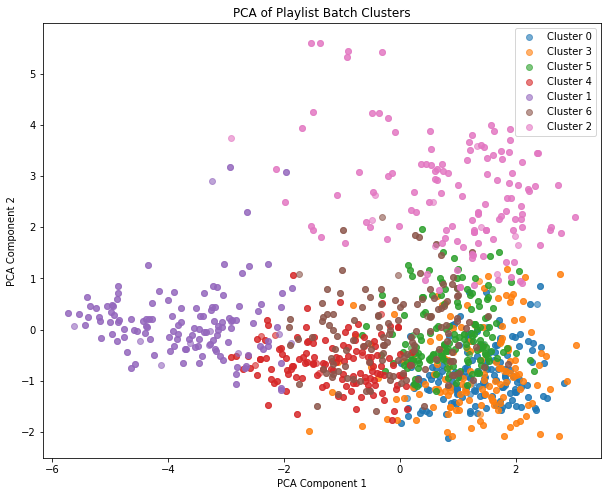

In [9]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA

def plot_pca_clusters(songs, playlist_batch):
    # Filter the original songs to include only those in the playlist batch
    batch_ids = [spotify_combined.loc[spotify_combined['track_name'] == song, 'track_id'].values[0]
                 for _, song in playlist_batch]
    batch_songs = songs[songs['track_id'].isin(batch_ids)].copy()

    # apply pca
    features = np.array(batch_songs['features'].tolist())  # Convert list of arrays to 2D array
    pca = PCA(n_components=2)
    pca_features = pca.fit_transform(features)
    
    # add to df
    batch_songs['PCA1'] = pca_features[:, 0]
    batch_songs['PCA2'] = pca_features[:, 1]

    # plot
    plt.figure(figsize=(10, 8))
    for cluster_id in batch_songs['cluster'].unique():
        cluster_data = batch_songs[batch_songs['cluster'] == cluster_id]
        plt.scatter(cluster_data['PCA1'], cluster_data['PCA2'], label=f'Cluster {cluster_id}', alpha=0.6)
    
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.title('PCA of Playlist Batch Clusters')
    plt.legend()
    plt.show()

plot_pca_clusters(spotify_combined, playlist_batch_1)

- As we can observe, the songs in each cluster fall into their own distinct regions (e.g. we see brown in the left corner, blue in the upper right, orange in the bottom right, etc). This means that the clustering algorithm is effectively separating the songs by their features.


- We also observe that the clusters overlap to a certain extent, but this is due to compressing 9 features into 2 dimensions. Qualitatively speaking, although many songs are perceived to be different (e.g. genre or mood), they may share many similarities such as tempo, energy, etc. Therefore, the overlap does not necessarily affect the diversity of the song characteristics.


- The fact that we can tell that the songs are separating into different regions, paired with the maximal distance selection function, guarantees the effectiveness of the cluster traversal.

### Cluster Distribution Plot

To visually confirm that the algorithm is traversing through the clusters, we plot the songs sequentially against their respective cluster number to observe if there are any repeating patterns. 

When using a small batch size (around 50), we can see that it is not an ordered pattern, meaning that the clusters are being correctly shuffled. When using a large batch size (around 750), we observe that the clusters are pretty evenly spaced. The fact that it looks random in small batches but relatively uniform in large batches means that the algorithm is doing a good job randomly shuffling the clusters every round while maintaiing a relatively fair distribution.

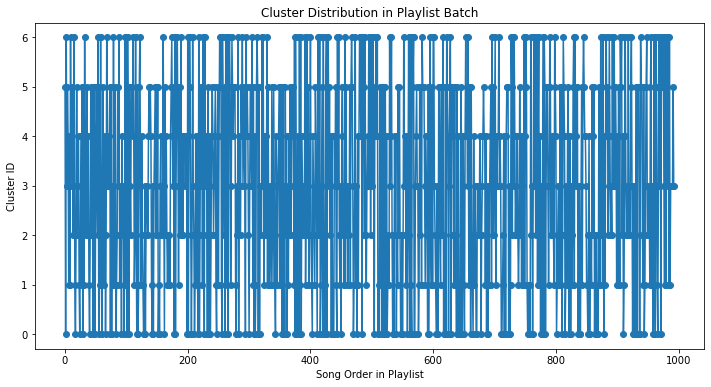

In [10]:
# Plot cluster distribution in the playlist batch
playlist_cluster_ids = [spotify_combined.loc[spotify_combined['track_name'] == song, 'cluster'].values[0] 
                        for _, song in playlist_batch_1]

plt.figure(figsize=(12, 6))
plt.plot(playlist_cluster_ids, marker='o', linestyle='-')
plt.xlabel("Song Order in Playlist")
plt.ylabel("Cluster ID")
plt.title("Cluster Distribution in Playlist Batch")
plt.show()

# Step 7: Quantitative Metrics

Below are a few quantitative metrics for a more concrete measurement of how well the algorithm is performing. We use a variety of methods, ranging from tracking the cluster traversal movement to seeing how large the euclidean distance is between each song played.

### Batch Cluster Traversal Rate

The first method we use is calculating the traversal rate, or the rate at which songs switch clusters after every turn. The method is implemented as follows:

1. Obtain all track IDs to track the songs (artist, name might not be completely accurate)
2. Obtain the track IDs of the songs that were in the cluster obtained previously
3. Obtain the cluster IDs of the songs from step 2 for cluster tracking
4. Implement a function that tracks whether or not the cluster IDs of two consecutive songs match, and then calculating the percentage of IDs that don't match

This is similar to the qualitative method used previously, where we plotted the cluster distribution over the number of songs. While the plot lets us visually inspect how the algorithm traverses the clusters, this is a more accurate percentage of how often it does.

In [11]:
batch_ids = [spotify_combined.loc[spotify_combined['track_name'] == song, 'track_id'].values[0]
             for _, song in playlist_batch_1]

# filter based on track id
batch_songs = spotify_combined[spotify_combined['track_id'].isin(batch_ids)]

# cluster id
playlist_cluster_ids = [batch_songs.loc[batch_songs['track_id'] == track_id, 'cluster'].values[0]
                        for track_id in batch_ids]

# transition rate function
def calculate_transition_rate(cluster_ids):
    transitions = sum(1 for i in range(1, len(cluster_ids)) if cluster_ids[i] != cluster_ids[i-1])
    return transitions / (len(cluster_ids) - 1)

batch_transition_rate = calculate_transition_rate(playlist_cluster_ids)
print("Batch Cluster Traversal Rate:", batch_transition_rate)


Batch Cluster Traversal Rate: 0.9546370967741935


### Feature Difference Percentage Between Songs

While the method above lets us see how the songs traverse between clusters, it doesn't tell us how different the songs truly are from each other. This is where our next method comes in. Earlier in the algorithm, we implemented a function to maximize the difference of each song every time it hopped clusters by getting the maximum euclidean distance between each song.

We use the same method to quantify how different our songs are. The method is implemented as follows:

1. Initialize total_distance to 0 and count to the length of the playlist chosen
2. Iterate over the length of the playlist (count), measuring the distance between consecutive songs
3. Return the total distance tracked over the count, effectively computing the average distance

In [12]:
import numpy as np

def calculate_feature_ranges(songs, feature_column='features'):
    
    features_array = np.array(songs[feature_column].tolist())
    # feature range calc
    feature_max = np.max(features_array, axis=0)
    feature_min = np.min(features_array, axis=0)
    feature_ranges = feature_max - feature_min
    return feature_ranges

Now that we have the feature distances between all of the songs, we can implement a function computing how different they are from each other. This is done with the following steps:

1. Retrieve all features of each song in the batch using batch_ids found earlier
2. Initialize the total_percentage_diff and the count to keep track of all of the percentages
3. Retrieve the features of consecutive songs and calculate the percentage difference
4. Take the average and assign that to total_percentage_diff
5. Take the average

In [13]:
def average_percentage_difference(playlist_songs, full_data, feature_ranges):

    features_list = [full_data.loc[full_data['track_id'] == track_id, 'features'].values[0]
                     for track_id in batch_ids]
    
    # initialize
    total_percentage_diff = 0
    count = len(features_list) - 1
    
    for i in range(count):
        
        song1_features = features_list[i]
        song2_features = features_list[i + 1]
        
        # song difference
        percentage_diffs = np.abs(song1_features - song2_features) / feature_ranges * 100
        
        # average percentage
        mean_percentage_diff = np.mean(percentage_diffs)
        total_percentage_diff += mean_percentage_diff
    
    return total_percentage_diff / count if count > 0 else 0

We finish of this metric measurement by calculating the feature ranges across the entire dataset. After that, we calculate the percentage differece and return it.

In [14]:
feature_ranges = calculate_feature_ranges(spotify_combined)

avg_percentage_diff = average_percentage_difference(playlist_batch_1, spotify_combined, feature_ranges)
print("Average Percentage Difference for Batch:", avg_percentage_diff)


Average Percentage Difference for Batch: 28.464908748939028


We observe that the average difference between each consecutive song is around 30%. This is a range where the playlist made has a decent amount of cohesiveness while still maintaining a threshold of variety. If we want to increase the average diversity in the future, adjustments can be made to the maximal distance selection function and the traversal algorithm.

# Future Consideration

Based on the PCA, we can roughly see that the music data does not have many spherical clusters, which is not ideal for K-means as one of its assumptions is that the data has a roughly circular/spherical pattern. For our purposes of simply grouping clusters to alternate between them, this is not detrimental, but the algorithm could benefit from other more flexible clustering algorithms such as Gaussian Mixture Model (cluster assumption is normal distribution) or DBSCAN (cluster assumption is based on density).